In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import random
import csv
import cv2
import ast
import collections
import os, os.path
import re
from matplotlib.image import imread

# Loading Original Dataset and BBox

In [0]:
# THIS IS FOR READING THE ORIGINAL DATASET AND ITS BOUNDING BOXES
 
#   NOTE1 : some index is not included in dataset, for example, there is NO image with name BloodImage_00025.jpg, it skipped from 24 to 26
#          therefore some images are missing, we do NOT have full 410 images

#   NOTE2 : MAKE SURE TO FILTER OUT IMAGES WITH BASOPHILS





#   get images, labels from original data
#   each image in the JPEGImages folder has name: BloodImage_00410.jpg ---> 410 is the image index
#   each image will be loaded in the imgs Dictionary, such that:
#   imgs[index] gives the image with that index

#  CHANGE THE PATH HERE TO FIT YOUR OWN
orig_dataset_path = '/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/'
img_path = orig_dataset_path + 'JPEGImages/'
imgs = {}
for f in os.listdir(img_path):
    index = int(re.findall('\d+', f)[0])
    imgs[index] =  imread(img_path + f)



#   This loads the bounding box and corresponding cell type label info for each image
#   CHANGE THE PATH HERE TO FIT YOUR OWN
with open('/content/gdrive/My Drive/APS360/APS360 Final Project/bbox.csv') as f:
    reader = csv.reader(f)
    label_data = [tuple(row) for row in reader]

print(label_data[0]) 
# this gives ('0', "[('NEUTROPHIL', (285, 169, 221, 206))]")
#  0 ---> represents index for BloodImage_00000.jpg, 
#  [('NEUTROPHIL', (285, 169, 221, 206))] ---> label, and bounding box in format (x_min, y_min, width, height)

#   This turns the above label_data into a dictionary, such that:
#   label_list[0]   = label and bounding box info for image 0
#                   = [('NEUTROPHIL', (285, 169, 221, 206))]
label_list = {}
for i in label_data:
    label_list[int(i[0])] = i[1]
#   to loop through the image and their corresponding labels:
j = 0
for i in sorted(imgs.keys()): 
    #   do what ever u need with this image and its labels
    # 
    if j > 10:
        break
    j+=1
    #print(imgs[i])
    print(label_list[i])

# Merge Images and Merge Labels

In [0]:
from PIL import Image
def merge_images(image1, image2, image3, image4):
    """Merge two images into one, displayed side by side
    :param file1: path to first image file
    :param file2: path to second image file
    :return: the merged Image object
    """
    # image1 = Image.open(file1)
    # image2 = Image.open(file2)
    # image3 = Image.open(file3)
    # image4 = Image.open(file4)
    (width, height) = image1.size

    result_width = 2*width
    result_height = 2*height

    result = Image.new('RGB', (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width, 0))
    result.paste(im=image3, box=(0, height))
    result.paste(im=image4, box=(width, height))
    result = result.resize((224, 224))
    return result

def merge_labels(l1, l2, l3, l4):
  merged_label = []
  for i in l1:
    cls = i[0]

    label = list(i[1])
    label = [x/2 for x in label]
    w_ratio = 224/640
    h_ratio = 224/480
    label[0] = label[0]*w_ratio
    label[1] = label[1]*h_ratio
    label[2] = label[2]*w_ratio
    label[3] = label[3]*h_ratio
    label = [round(x) for x in label]
    label = tuple(label)
    merged_label.append((cls,label))
  for i in l2:
    cls = i[0]
    label = list(i[1])
    label = [x/2 for x in label]
    label[0] += 640/2
    w_ratio = 224/640
    h_ratio = 224/480
    label[0] = label[0]*w_ratio
    label[1] = label[1]*h_ratio
    label[2] = label[2]*w_ratio
    label[3] = label[3]*h_ratio
    label = [round(x) for x in label]
    label = tuple(label)
    merged_label.append((cls,label))
  for i in l3:
    cls = i[0]
    label = list(i[1])
    label = [x/2 for x in label]
    label[1] += 480/2
    w_ratio = 224/640
    h_ratio = 224/480
    label[0] = label[0]*w_ratio
    label[1] = label[1]*h_ratio
    label[2] = label[2]*w_ratio
    label[3] = label[3]*h_ratio
    label = [round(x) for x in label]
    label = tuple(label)
    merged_label.append((cls,label))
  for i in l4:
    cls = i[0]
    label = list(i[1])
    label = [x/2 for x in label]
    label[0] += 640/2
    label[1] += 480/2
    w_ratio = 224/640
    h_ratio = 224/480
    label[0] = label[0]*w_ratio
    label[1] = label[1]*h_ratio
    label[2] = label[2]*w_ratio
    label[3] = label[3]*h_ratio
    label = [round(x) for x in label]
    label = tuple(label)
    merged_label.append((cls,label))
  return merged_label

In [0]:
def generate_rand_image(src_path, start, end):
  while True:
    num = random.randint(start, end)
    s = '%0*d' % (3, num)
    image_path = src_path + "/BloodImage_00" + s+ ".jpg"
    try:
      image = Image.open(image_path)
      return image, num
    except FileNotFoundError:
      # print("Can't find this path: {}, generate a new one")
      continue
  print("we shouldn't get here")
  return None


def get_bbox_list(idx):
  csv_path = '/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/bbox2.csv'
  with open(csv_path) as f:
    f_reader = csv.reader(f, delimiter=',')
    for row in f_reader:
      if row[0] == str(idx):
        ret = list(ast.literal_eval(row[1]))
        return ret
    else:
      print("so bad, idx is {}".format(idx))

def get_merged_list(idx):
  csv_path = '/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/Merged Labels/ValidationLabels.csv'
  with open(csv_path) as f:
    f_reader = csv.reader(f, delimiter=',')
    for row in f_reader:
      if row[0] == str(idx):
        ret = list(ast.literal_eval(row[1]))
        return ret
    else:
      print("so bad, idx is {}".format(idx))

def build_merged_dataset(s):
  src_path = '/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/JPEGImages'
  dest_path = '/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/Merged Images2/'+s

  #add this to create list of info
  info_list = []
  start = 0
  end = 0
  #count for each class
  if s=="Train":
    num = 1000
    start = 0
    end = 200
  elif s=="Validation":
    num = 500
    start = 201
    end = 301
  else:
    num = 500
    start = 302
    end = 410
  for i in range(0, num):
    image1,idx1 = generate_rand_image(src_path, start, end)
    image2,idx2 = generate_rand_image(src_path, start, end)
    image3,idx3 = generate_rand_image(src_path, start, end)
    image4,idx4 = generate_rand_image(src_path, start, end)
    l1 = get_bbox_list(idx1)
    l2 = get_bbox_list(idx2)
    l3 = get_bbox_list(idx3)
    l4 = get_bbox_list(idx4)
    merged_image = merge_images(image1, image2, image3, image4)
    merged_label = merge_labels(l1, l2, l3, l4)
    # plot_img_with_bbx(merged_image, merged_label)

    #append merged image to info list
    merged_label.sort(key=lambda a: a[0])
    info_list.append(merged_label)

    merged_path = dest_path+"/merged_"+str(i)+".jpg"
    merged_image.save(merged_path)
  return info_list

def plot_img_with_bbx(img, label_list):
  img_copy = np.array(img.copy())
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3,3))
  for i in label_list:
    x,y,w,h = i[1]
    cv2.rectangle(img_copy,(x,y),(x+w,y+h),(255,0,0),3)
  ax.imshow(img_copy)

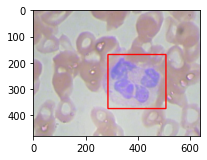

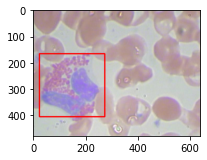

In [0]:
img0 = Image.open('/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/JPEGImages/BloodImage_00000.jpg')
label_list0 = get_bbox_list(0)
plot_img_with_bbx(img0, label_list0)

img9 = Image.open('/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/JPEGImages/BloodImage_00009.jpg')
label_list9 = get_bbox_list(9)
plot_img_with_bbx(img9, label_list9)

In [0]:
def count_class(info_list):
    class_table = {} #creates a dictionary

    for items in info_list:
        if items[0] not in class_table:
            class_table[items[0]] = 1
        else:
            class_table[items[0]] +=1

    return class_table

def create_label_csv(info_list, s):
    path = '/content/gdrive/My Drive/APS360/APS360 Final Project/Dataset/dataset1/Merged Labels2/'
    name = s+'Labels.csv'
    with open(path + name, 'w', newline='') as file:
        field_names = ['index', 'class_info', 'class_count']
        writer = csv.DictWriter(file, fieldnames=field_names)
        writer.writeheader()
        index_num = 0
        for items in info_list:
            writer.writerow({'index': index_num, 'class_info': items, 'class_count': count_class(items)})
            index_num+=1

# Build Train, Validation and Test Dataset for RCNN Model

In [0]:
train_info_list = build_merged_dataset("Train")
create_label_csv(train_info_list, "Train")

val_info_list = build_merged_dataset("Validation")
create_label_csv(val_info_list, "Validation")

test_info_list = build_merged_dataset("Test")
create_label_csv(test_info_list, "Test")